<a href="https://colab.research.google.com/github/Rockgecko/LearningByHacking/blob/master/Birdsong_classification_hackday_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackday project to build a bird song classifier using Deep Learning (2019-04-05)

An exercise to introduce myself to a basic DL classifier.  
I wanted to try this out on bird song audio, so spent some time first exploring how to obtain example audio files from the Xenocanto website and then
to generate features.  
This did not leave much time for the actual classification work, so there is much to return to.  
It would also be interesting to compare results of using sonograms as the input to the classifier rather than MFCCs.  

## Step1: Acquiring bird song data files

As a toy data set, grab a set of example recordings of robins and wrens from xenocanto...

In [ ]:
import logging
import json 
import math
import shutil
from requests import get, Session
from typing import List
import pandas as pd

# Set up the basic search pararms
server = "https://www.xeno-canto.org/api/2/recordings"
country = "united kingdom"
wren = {"label": "wren", "search_string": "troglodytes troglodytes"} 
robin = {"label": "robin", "search_string": "erithacus rubecula"} 


# nums of recordings to dl per query, use 0 for all available, try 10 or 15 to test
num_downloads = 100 
# rate of printing messages during download            
alert_rate = 2

session = Session()

Define functions

In [ ]:

def build_query(query_string: str) -> dict:
    """Construct payload for bird name search."""
    return {'query': query_string}
    


In [ ]:
# get list of recordings

def get_recordings_list(session: Session, server: str, payload: dict, num_pages: int) -> List:
    """Build a list of available recordings for the given search."""
    start_page = 1
    max_pages=1
    recordings=[]
    for page in range(start_page, min(max_pages + start_page, num_pages + start_page)):
        payload["page"] = page
        r = session.get(server, params=payload)
        data_buffer = r.json()
        recordings += data_buffer['recordings']
    del(data_buffer)
    return recordings
    

def get_pages(session: Session, server: str, payload: dict) -> int:
    """Check number of pages returned by search."""
    r = session.get(server, params=payload)
    data = r.json()
    num_recordings = int(data['numRecordings'])
    logging.info(f"number of available recordings: {num_recordings}")
    del(data)   
    return math.ceil(num_recordings / 500)


In [ ]:
# function to download a file
def download_file(url: str) -> str:
    """Download an audio recording given its url and return the name of the local file saved."""
    filename_start = url.find("/", 23)                                #Example : for given url "www.cs.berkeley.edu/~vazirani/algorithms/chap6.pdf" file_name will store "chap6.pdf"
    filename_end = url.find("/", 28)
    local_filename = url[filename_start+1:filename_end] + ".mp3"
    r = get(url, stream=True)
    with open(local_filename, 'wb') as f:
        shutil.copyfileobj(r.raw, f)

    return local_filename

In [ ]:
# check number of pages

downloaded_files = []
labels = []
for bird in [robin, wren]:
    payload = build_query(bird["search_string"])
    num_pages = get_pages(session, server, payload)  
    
    # build the list of recordings
    recordings = get_recordings_list(session, server, payload, num_pages)
    logging.info(f"{len(recordings)} found")

    # Now build the list of source file paths 
    file_paths=[]
    for recording in recordings:
        file_paths.append("http:" + recording["file"])
    logging.info(f"number of possible {bird} files to download: {len(file_paths)}")
    if num_downloads == 0:
        num_downloads = len(recordings)
    else:
        logging.info(f"but only downloading : {num_downloads}")
    
    # and download the set of audio files
    for dl_idx, file_path in enumerate(file_paths[0:num_downloads]):
        if(dl_idx % alert_rate == 0):
            logging.info(f"downloading nr : {dl_idx}")
        local_file = download_file(file_path)
        downloaded_files.append(local_file)
        labels.append(bird["label"])

logging.info("Audio downloading complete")
    

In [ ]:
dataset= pd.DataFrame(data={"filename": downloaded_files, "label": labels}, index=range(len(labels)))
dataset.head()


,filename,label
0,600136.mp3,robin
1,599981.mp3,robin
2,599723.mp3,robin
3,599708.mp3,robin
4,599707.mp3,robin


## Step 2: quick check of the audio files

In [ ]:
%matplotlib inline
import os
import librosa
import librosa.display
import glob 
import IPython.display as ipd
import matplotlib.pylab as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam


In [ ]:
# can playback a file here
selected_idx = 13
example_file = dataset.iloc[selected_idx]["filename"]
label = dataset.iloc[selected_idx]["label"]
print(label)
ipd.Audio(example_file)


robin


In [ ]:
# to load an audio file
data, sampling_rate = librosa.load(example_file, res_type='kaiser_fast')

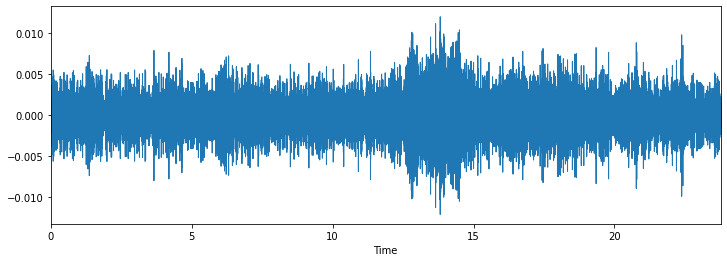

In [ ]:
# to display an audio file
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

In [ ]:
# to generate Mel-frequency cepstral coefficients (MFCCs)
mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40).T,axis=0) 
display(mfccs)

array([-5.76580181e+02,  1.27511045e+02,  4.11679785e+01,  2.52814191e+00,
       -1.01663345e+01,  3.31367184e+01,  9.36373276e+00,  3.47611410e+01,
       -4.64856015e+00,  2.27043467e+01, -7.21425640e+00,  1.62275035e+01,
       -4.81755544e+00,  7.31329672e+00, -7.67418633e+00,  5.12724283e+00,
       -5.96883809e+00,  3.61943321e+00, -8.17370123e+00,  2.42599055e+00,
       -4.43399055e+00,  2.17069956e+00, -3.65914586e+00, -9.92180485e-01,
        5.49972308e-01, -1.42301494e+00, -2.00404411e+00,  1.31754474e+00,
       -3.30666396e+00,  2.75034101e-01, -1.44513253e+00, -1.96188890e+00,
       -6.85660009e-01, -1.62959996e+00, -2.03265023e+00, -3.60798914e-01,
       -2.31246791e+00, -1.10361356e+00, -1.48173300e+00, -5.64383151e-01])

## Step 3: create test and training sets

In [ ]:
# need to split into training and test (this is far too few files really, but this is just to get the process working)

train, test = train_test_split(dataset, test_size=0.2)
print(len(train))
print(len(test))

160
40


## Step 4: Load data and generate features

In [ ]:
def parser(row: pd.DataFrame) -> List:
   """Load files and extract features."""
   file_name = row["filename"]

   # handle exceptions: keep going if there is a file which is corrupted
   try:
      # here kaiser_fast is a technique used for faster extraction
      X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
      # extract mfcc features from data
      mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
   except Exception as e:
      print("Error encountered while parsing file: ", file)
      return [None, None]
 

   return [mfccs, row["label"]]


In [ ]:
# prepare training data
training_features = train.apply(parser, axis=1, result_type="expand")
training_features.columns = ['feature', 'label']

X = np.array(training_features.feature.tolist())
y = np.array(training_features.label.tolist())

lb = LabelEncoder()

y = np_utils.to_categorical(lb.fit_transform(y))

In [ ]:
# prepare test data also
test_features = test.apply(parser, axis=1, result_type="expand")
test_features.columns = ['feature', 'label']

Xtest = np.array(test_features.feature.tolist())
ytest = np.array(test_features.label.tolist())

lb = LabelEncoder()

ytest = np_utils.to_categorical(lb.fit_transform(ytest))

## Step 5: Define and compile model

In [ ]:

# build model
num_labels = y.shape[1]

model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

## Train Model

In [ ]:
model.fit(X, y, batch_size=32, epochs=500)

Epoch 1/500
5/5 [==============================] - 0s 2ms/step - loss: 20.3771 - accuracy: 0.4938
Epoch 2/500
5/5 [==============================] - 0s 2ms/step - loss: 21.0300 - accuracy: 0.5000
Epoch 3/500
5/5 [==============================] - 0s 2ms/step - loss: 14.2244 - accuracy: 0.5500
Epoch 4/500
5/5 [==============================] - 0s 3ms/step - loss: 17.1668 - accuracy: 0.5250
Epoch 5/500
5/5 [==============================] - 0s 3ms/step - loss: 15.4568 - accuracy: 0.5500
Epoch 6/500
5/5 [==============================] - 0s 3ms/step - loss: 11.9513 - accuracy: 0.5562
Epoch 7/500
5/5 [==============================] - 0s 2ms/step - loss: 10.5162 - accuracy: 0.5375
Epoch 8/500
5/5 [==============================] - 0s 2ms/step - loss: 9.6644 - accuracy: 0.5312
Epoch 9/500
5/5 [==============================] - 0s 2ms/step - loss: 10.4943 - accuracy: 0.5063
Epoch 10/500
5/5 [==============================] - 0s 2ms/step - loss: 7.4845 - accuracy: 0.5875
Epoch 11/500
5/5 [===

## Step 6: Test the Model

In [ ]:
test_loss, test_accuracy = model.evaluate(Xtest, ytest)
print('Accuracy on test dataset:', test_accuracy)

2/2 [==============================] - 0s 1ms/step - loss: 0.7034 - accuracy: 0.8750
Accuracy on test dataset: 0.875


In [ ]:
predictions = model.predict(Xtest)

In [ ]:
for prediction, yt in zip(predictions, ytest):
    predicted_label = np.argmax(predictions[1])
    true_label = np.argmax(yt)
    print(f"Predicted label: {lb.classes_[predicted_label]}; True label: {lb.classes_[true_label]}")


Predicted label: wren; True label: wren
Predicted label: wren; True label: wren
Predicted label: wren; True label: wren
Predicted label: wren; True label: wren
Predicted label: wren; True label: robin
Predicted label: wren; True label: robin
Predicted label: wren; True label: wren
Predicted label: wren; True label: wren
Predicted label: wren; True label: wren
Predicted label: wren; True label: wren
Predicted label: wren; True label: wren
Predicted label: wren; True label: robin
Predicted label: wren; True label: wren
Predicted label: wren; True label: wren
Predicted label: wren; True label: wren
Predicted label: wren; True label: wren
Predicted label: wren; True label: wren
Predicted label: wren; True label: wren
Predicted label: wren; True label: robin
Predicted label: wren; True label: robin
Predicted label: wren; True label: robin
Predicted label: wren; True label: wren
Predicted label: wren; True label: wren
Predicted label: wren; True label: wren
Predicted label: wren; True label: